# Libraries

In [16]:
import sys
sys.path.append("../")

In [17]:
# for working with data
import pandas as pd
import numpy as np
from src.data_exploration import explore_functions as explr

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# warning
import warnings 
warnings.filterwarnings('ignore') 

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

# for preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import WoEEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# for evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

# for tuning
import optuna
import joblib

In [18]:
def check_balance(data, target, chart_types="pie", normalize=True, positive_target=0):
    target_counts = data[target].value_counts()
    target_counts.index = ["non-default" if i==positive_target else "default" for i in target_counts.index] 
    # sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index)
    if chart_types == "pie":
        plt.pie(target_counts.values, labels=target_counts.index, normalize=normalize, startangle=90,
            autopct="%1.1f%%", explode=[0, 0.1])
    elif chart_types == "bar":
        sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette="tab10")
        plt.xlabel("Targets")
    plt.title("Distribution of Targets")

def distribution_barplot(data, feature, normalize=True, title=None, legend="auto", labels=None):
    feature_count = data[feature].value_counts(normalize=normalize).reset_index()
    sns.barplot(x=feature_count[feature], y=feature_count.iloc[:, 1], hue=feature_count.iloc[:, 0],
                palette="Set2", legend=legend)      
    plt.xlabel(feature)
    plt.title(f"Distribution of {feature}")

def distitribution_otherbased(data, dist_feature, base_feature, normalize=False):
    dist = data.groupby(by=base_feature, as_index=False)[dist_feature].value_counts(normalize=normalize)
    sns.barplot(x=dist[base_feature], y=dist.iloc[:, -1], hue=dist[dist_feature])
    if normalize:
        plt.ylim(0, 1.05)

# Load Data

In [19]:
data_org = pd.read_csv("../data/taiwan_default_payments.csv")
data_org.head()

,default,id,limit_bal,gender,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,1,1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,1,2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,3,90000,female,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,4,50000,female,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,5,50000,male,university,married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


# Train Test Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data_org.iloc[:, 1:], data_org.iloc[:, 0], test_size=0.2,
                                                    shuffle=True, random_state=42)
print(f"Training Set: {x_train.shape[0]} observations")
print(f"Testing Set: {x_test.shape[0]} observations")

Training Set: 24000 observations
Testing Set: 6000 observations


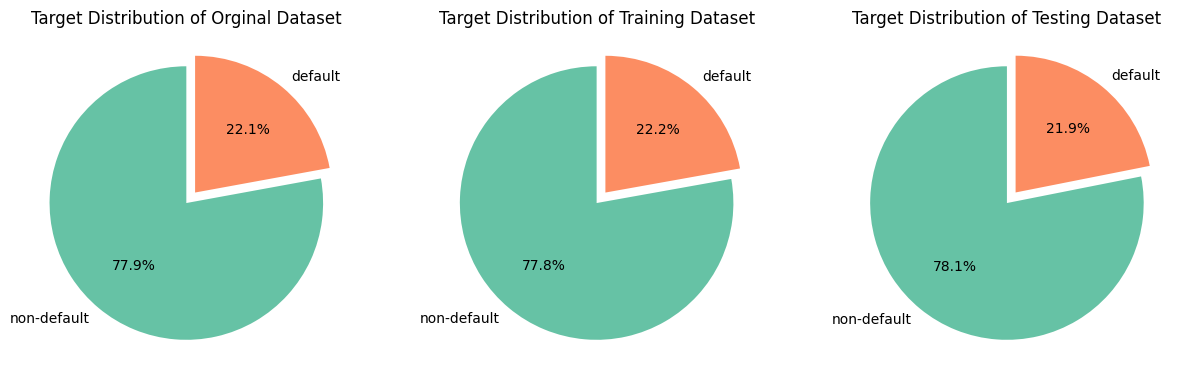

In [21]:
plt.figure(figsize=(15, 5))
dataset = [data_org, pd.DataFrame(y_train), pd.DataFrame(y_test)]
titles = ["Target Distribution of Orginal Dataset",
          "Target Distribution of Training Dataset",
          "Target Distribution of Testing Dataset"]
for i in range(3):
    plt.subplot(1, 3, i+1)
    check_balance(data=dataset[i], target="default")
    plt.title(titles[i])

# Preprocessing

In [22]:
class Preprocessing:
    def __init__(self, scaler=None, encoder=None, numeric_to_object=None,
                 numeric_into_bins=None, specific_encoders=None, balance=None):
        self.scaler = scaler
        self.encoder = encoder
        self.specific_encoders = specific_encoders
        self.num_to_obj = numeric_to_object
        self.numbins = numeric_into_bins
        self.cate_feas = None
        self.num_feas = None
        self.balance = balance
        self.imputer = SimpleImputer()
    
    def fit(self, X, y):
        data = X.copy()

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numbins is not None:
            for feature, bins in self.numbins.items():
                if not isinstance(bins, dict):
                    self.numbins[feature] = self.create_bins(data[feature], bins=bins)
                data[feature] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])

        self.cate_feas = list(data.select_dtypes(include="object").columns)
        self.num_feas = [col for col in data.columns if col not in self.cate_feas]

        if self.specific_encoders is not None:
            self.cate_feas = [col for col in self.cate_feas if col not in self.specific_encoders.keys()]
            for feature, encoder in self.specific_encoders.items():
                if not isinstance(encoder, OneHotEncoder):
                    if isinstance(encoder, WoEEncoder):
                        self.specific_encoders[feature].fit(X=data[feature], y=y)
                    else:
                        self.specific_encoders[feature].fit(data[feature])
                else:
                    self.specific_encoders[feature].fit(data[[feature]])

        self.scaler.fit(data[self.num_feas])

        if isinstance(self.encoder, WoEEncoder):
            self.encoder.fit(X=data[self.cate_feas], y=y)
        else:
            self.encoder.fit(data[self.cate_feas])
        
        # data = self.transform(data)
        # self.imputer.fit(data)

    def fit_transform(self, X, y):
        self.fit(X, y)
        data = self.transform(X, train_set=True)
        if self.balance is not None:
            new_data, new_labels = self.balance.fit_resample(data, y)
            return new_data, new_labels
        return data

    def transform(self, X, train_set=False):
        data = X.copy()

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numbins is not None:
            for feature in self.numbins.keys():
                data[feature] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])

        if self.specific_encoders is not None:
            for feature, encoder in self.specific_encoders.items():
                if isinstance(encoder, OneHotEncoder):
                    encoded = self.specific_encoders[feature].transform(data[[feature]]).toarray()
                    encoded = pd.DataFrame(encoded, columns=self.specific_encoders[feature].get_feature_names_out(), index=data.index)
                    data = pd.concat([data, encoded], axis=1)
                    data = data.drop(feature, axis=1)
                else:
                    data[feature] = self.specific_encoders[feature].transform(data[feature])

        data[self.num_feas] = self.scaler.transform(data[self.num_feas])
        
        if isinstance(self.encoder, OneHotEncoder):
            encoded = self.encoder.transform(data[self.cate_feas]).toarray()
            encoded = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(), index=data.index)
            data = pd.concat([data, encoded], axis=1)
            data = data.drop(self.cate_feas, axis=1)
        else:
            data[self.cate_feas] = self.encoder.transform(data[self.cate_feas])
        
        if train_set:
            self.imputer.fit(data)
        else:
            data_filled = self.imputer.transform(data)
            data = pd.DataFrame(data_filled, columns=self.imputer.get_feature_names_out(), index=data.index)

        return data
    
    def create_bins(self, feature, bins):
        bins = pd.cut(feature, bins=bins, right=False, retbins=True)[1]
        bins_dict = {}
        for i in range(len(bins)-1):
            if i==0:
                bins_name = f"under {bins[i]}"
                lower = bins[i]-10**10
                upper = bins[i+1]
            elif i==len(bins)-2:
                bins_name = f"over {bins[i]}"
                lower = bins[i]
                upper = bins[i+1]
            else:
                bins_name = f"{bins[i]} - {bins[i+1]}"
                lower = bins[i]
                upper = bins[i+1] + 10**10
            bins_dict[(lower, upper)] = bins_name
        return bins_dict
            
    def convert_into_bins(self, X, feature, bins):
        data = X.copy()
        for bins, bins_name in bins.items():
            data.loc[data[feature].between(bins[0], bins[1], "right"), f"{feature}_bins"] = bins_name
        return data.iloc[:, -1]

In [23]:
class DefaultPaymentClassifier:
    def __init__(self, processor, model, balance=None, threshold=0.5):
        self.processor = processor
        self.model = model
        self.balance = balance
        self.threshold = threshold
    
    def fit(self, X, y):
        processed_x = self.processor.fit_transform(X, y)
        if self.balance is not None:
            processed_x, y = self.balance.fit_resample(processed_x, y)
        # return processed_x, y
        self.model.fit(processed_x, y)

    def predict(self, X):
        processed_x = self.processor.transform(X)
        if self.threshold == 0.5:
            predited = self.model.predict(processed_x)
        else:
            prob = self.model.predict_proba(processed_x).T[1]
            predited = np.array([1 if i >= self.threshold else 0 for i in prob])
        return predited
    
    def predict_proba(self, X):
        processed_x = self.processor.transform(X)
        predicted_proba = self.model.predict_proba(processed_x)
        return predicted_proba

In [24]:
def evaluation(y_true, y_pred, y_pred_prob, scoring=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    scores = {'accuracy': accuracy_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'roc_auc': roc_auc_score}
    
    result = {}
    for method in scoring:
        if method == 'roc_auc':
            result[method] = scores[method](y_true, y_pred_prob.T[1])
        else:
            result[method] = scores[method](y_true, y_pred)

    return result

def cross_validation(X, y, estimator, cv=5, random_state=42, methods=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = {method: [] for method in methods}
    for train_index, test_index in skf.split(X, y):
        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        x_test, y_test = X.iloc[test_index], y.iloc[test_index]

        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)
        y_pred_proba = estimator.predict_proba(x_test)

        score = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_proba)
        for method in scores.keys():
            scores[method].append(score[method])

    avg_scores = {key: np.mean(values) for key, values in scores.items()}
    return avg_scores

def modelling_evaluation(estimator, x_train, y_train, x_test, y_test, scoring=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    y_pred_proba = estimator.predict_proba(x_test)
    scores = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_proba)
    return scores

In [25]:
processor = Preprocessing(scaler=MinMaxScaler(),
                         encoder=WoEEncoder(fill_value=0.00001),
                         numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                         numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
model = joblib.load("../models/lgbm_best.pkl")
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(), threshold=0.5)
cross_validation(estimator=estimator, X=x_train.iloc[:, 1:], y=y_train)

{'roc_auc': 0.7737404456310807,
 'accuracy': 0.7952916666666667,
 'f1': 0.5430547661773915,
 'precision': 0.5380809641184501,
 'recall': 0.5487588690034946}

# Phase 1 - Logistic Regression + Different Preprocessing Techniques

In this phase, we will use Logistic Regression as a baseline model and try some different preprocessing methods to find the best one.

In [26]:
try:
    output_df = pd.read_csv("../output/csv/phase_1/all_results.csv")
except:
    output = {"categorical_features": [],
                "encoder": [],
                "scaler": [],
                "smote": [],
                "roc_auc": [],
                "accuracy": [],
                "f1": [],
                "precision": [],
                "recall": []}

    testcases = {"cate": [["gender", "marriage", "education"],
                          ["gender", "marriage", "education", "age"],
                          ["gender", "marriage", "education", "pay_x"],
                          ["gender", "marriage", "education", "age", "pay_x"],
                          ["gender", "marriage", "education", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "pay_x", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "pay_x", "bill_amt", "pay_amt"]],
                 "encoder": {"OrdinalEncoder": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                             "OneHotEncoder": OneHotEncoder(handle_unknown="ignore"),
                             "WoE": WoEEncoder(fill_value=0.00001, )},
                 "scaler": {"MinMaxScaler": MinMaxScaler(),
                            "StandardScaler": StandardScaler()},
                 "smote": {0: None, 1: SMOTE()}}

    model = LogisticRegression(max_iter=1000)

    for cate_cols in testcases['cate']:
        numbins = {}
        if 'age' in cate_cols:
            numbins["age"] = {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40", (40, 50): "40-50",
                              (50, 60): "50-60", (60, 100): "over 60"}
        if "pay_x" in cate_cols:
            num_to_cate = [f"pay_{i}" for i in range(1, 7, 1)]
        else:
            num_to_cate = None
        if ("bill_amt" in cate_cols) and ("pay_amt" in cate_cols):
            billbins = {f"bill_amt{i}": 10 for i in range(1, 7, 1)}
            paybins = {f"pay_amt{i}": 10 for i in range(1, 7, 1)}
            numbins.update(billbins)
            numbins.update(paybins)
        if len(numbins) == 0:
            numbins = None
        for scaler_name, scaler in testcases["scaler"].items():
            for encoder_name, encoder in testcases["encoder"].items():
                for smote_used, smote in testcases['smote'].items():
                    processor = Preprocessing(scaler=scaler,
                                            encoder=encoder,
                                            numeric_into_bins=numbins,
                                            numeric_to_object=num_to_cate,
                                            specific_encoders={"gender": LabelEncoder()})
                    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=smote)
                    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
                    output["categorical_features"].append(", ".join(cate_cols))
                    output["encoder"].append(encoder_name)
                    output["scaler"].append(scaler_name)
                    output["smote"].append(smote_used)
                    for method, score in scores.items():
                        output[method].append(score)
    output_df = pd.DataFrame(output)
    output_df.to_csv("../output/csv/phase_1/all_results.csv", index=False)

### Different Ways to Dealing with Numerical Features
__Treating as Categorical Features__

In [27]:
# validation
try:
    handle_num_valid = pd.read_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_valid.csv")
except:
    output = {"categorical_features": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

    testcases = {"cate": [["gender", "marriage", "education"],
                          ["gender", "marriage", "education", "age"],
                          ["gender", "marriage", "education", "pay_x"],
                          ["gender", "marriage", "education", "age", "pay_x"],
                          ["gender", "marriage", "education", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "pay_x", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "pay_x", "bill_amt", "pay_amt"]],
                 "encoder": {"WoE": WoEEncoder(fill_value=0.00001)},
                 "scaler": {"MinMaxScaler": MinMaxScaler()}}

    model = LogisticRegression(max_iter=1000)

    for cate_cols in testcases['cate']:
        numbins = {}
        if 'age' in cate_cols:
            numbins["age"] = {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40", (40, 50): "40-50",
                              (50, 60): "50-60", (60, 100): "over 60"}
        if "pay_x" in cate_cols:
            num_to_cate = [f"pay_{i}" for i in range(1, 7, 1)]
        else:
            num_to_cate = None
        if ("bill_amt" in cate_cols) and ("pay_amt" in cate_cols):
            billbins = {f"bill_amt{i}": 10 for i in range(1, 7, 1)}
            paybins = {f"pay_amt{i}": 10 for i in range(1, 7, 1)}
            numbins.update(billbins)
            numbins.update(paybins)
        if len(numbins) == 0:
            numbins = None
        processor = Preprocessing(scaler=MinMaxScaler(),
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins=numbins,
                                  numeric_to_object=num_to_cate,
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["categorical_features"].append(", ".join(cate_cols))
        for method, score in scores.items():
            output[method].append(score)
    handle_num_valid = pd.DataFrame(output)
    handle_num_valid.to_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_valid.csv", index=False)

In [28]:
# testing
try:
    handle_num_test = pd.read_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_test.csv")
except:
    output = {"categorical_features": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

    testcases = {"cate": [["gender", "marriage", "education"],
                          ["gender", "marriage", "education", "age"],
                          ["gender", "marriage", "education", "pay_x"],
                          ["gender", "marriage", "education", "age", "pay_x"],
                          ["gender", "marriage", "education", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "pay_x", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "pay_x", "bill_amt", "pay_amt"]],
                 "encoder": {"WoE": WoEEncoder(fill_value=0.00001)},
                 "scaler": {"MinMaxScaler": MinMaxScaler()}}

    model = LogisticRegression(max_iter=1000)

    for cate_cols in testcases['cate']:
        numbins = {}
        if 'age' in cate_cols:
            numbins["age"] = {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40", (40, 50): "40-50",
                              (50, 60): "50-60", (60, 100): "over 60"}
        if "pay_x" in cate_cols:
            num_to_cate = [f"pay_{i}" for i in range(1, 7, 1)]
        else:
            num_to_cate = None
        if ("bill_amt" in cate_cols) and ("pay_amt" in cate_cols):
            billbins = {f"bill_amt{i}": 10 for i in range(1, 7, 1)}
            paybins = {f"pay_amt{i}": 10 for i in range(1, 7, 1)}
            numbins.update(billbins)
            numbins.update(paybins)
        if len(numbins) == 0:
            numbins = None
        processor = Preprocessing(scaler=MinMaxScaler(),
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins=numbins,
                                  numeric_to_object=num_to_cate,
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["categorical_features"].append(", ".join(cate_cols))
        for method, score in scores.items():
            output[method].append(score)
    handle_num_test = pd.DataFrame(output)
    handle_num_test.to_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_test.csv", index=False)

In [29]:
handle_num_valid

,categorical_features,roc_auc,accuracy,f1,precision,recall
0,"gender, marriage, education",0.718286,0.808417,0.346787,0.711126,0.229384
1,"gender, marriage, education, age",0.718185,0.808250,0.344515,0.712078,0.227317
2,"gender, marriage, education, pay_x",0.762882,0.820250,0.471104,0.677995,0.361079
3,"gender, marriage, education, age, pay_x",0.762725,0.820292,0.471276,0.678011,0.361268
4,"gender, marriage, education, bill_amt, pay_amt",0.723186,0.806500,0.346986,0.690223,0.231825
5,"gender, marriage, education, age, bill_amt, pay_amt",0.722962,0.806250,0.347065,0.687365,0.232200
6,"gender, marriage, education, pay_x, bill_amt, pay_amt",0.762565,0.820167,0.468785,0.679817,0.357886
7,"gender, marriage, education, age, pay_x, bill_amt, pay_amt",0.762175,0.819833,0.467631,0.678457,0.356947


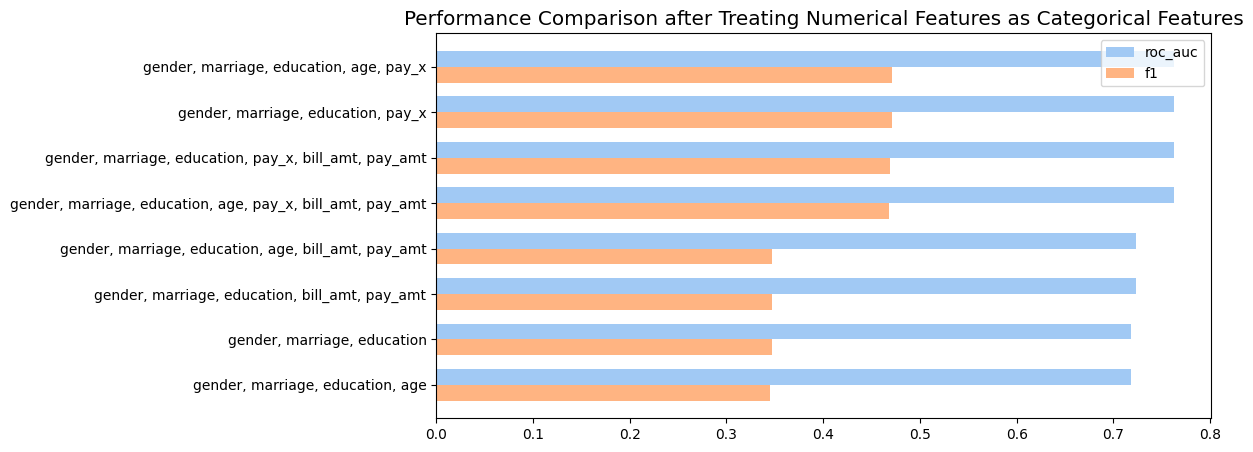

In [30]:
sns.set_palette("pastel")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

handle_num_valid = handle_num_valid.sort_values(by=["f1", "roc_auc", "accuracy"], ascending=True)

y = np.arange(handle_num_valid.shape[0])
ax.barh(y=handle_num_valid.iloc[:, 0], width=handle_num_valid.iloc[:, 1], height=0.35, label="roc_auc", alpha=1, align="edge")
ax.barh(y=y-0.35, width=handle_num_valid.iloc[:, 3], height=0.35, label="f1", alpha=1, align="edge")
ax.set_title("Performance Comparison after Treating Numerical Features as Categorical Features",fontsize="x-large")
ax.legend(loc=0)

In [33]:
# valid
try:
    scaler = pd.read_csv("../output/csv/phase_1/handling_numeric/scaler.csv")
except:
    output = {"scaler": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], "dataset": []}

    testcases = {"scaler": {"MinMaxScaler": MinMaxScaler(), "StandardScaler": StandardScaler()}}

    model = LogisticRegression(max_iter=1000)

    for scaler_name, scaler in testcases['scaler'].items():
        processor = Preprocessing(scaler=scaler,
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["dataset"].append("validation")
        output["scaler"].append(scaler_name)
        for method, score in scores.items():
            output[method].append(score)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["dataset"].append("testing")
        output["scaler"].append(scaler_name)
        for method, score in scores.items():
            output[method].append(score)
    scaler = pd.DataFrame(output)
    scaler.to_csv("../output/csv/phase_1/handling_numeric/scaler.csv", index=False)

In [34]:
scaler

,scaler,roc_auc,accuracy,f1,precision,recall,dataset
0,MinMaxScaler,0.762725,0.820292,0.471276,0.678011,0.361268,validation
1,MinMaxScaler,0.759989,0.817000,0.452096,0.655572,0.345011,testing
2,StandardScaler,0.765082,0.820083,0.470081,0.677842,0.359953,validation
3,StandardScaler,0.764188,0.818167,0.455860,0.660405,0.348058,testing


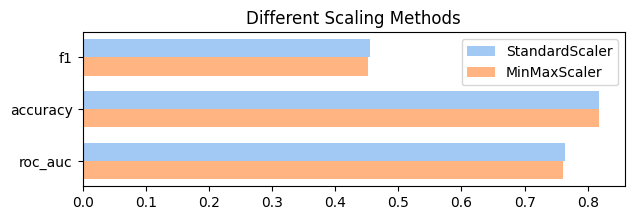

In [82]:
sns.set_palette("pastel")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 2))

scaler_valid = scaler[scaler['dataset']!="validation"].iloc[:, :4].sort_values(by=["f1", "roc_auc"], ascending=False)

y = np.arange(scaler_valid.shape[1]-1)
ax.barh(y=scaler_valid.columns[1:], width=scaler_valid.iloc[0, 1:], height=0.35, align="edge", label=scaler_valid.iloc[0, 0])
ax.barh(y=y-0.35, width=scaler_valid.iloc[1, 1:], height=0.35, alpha=1, align="edge", label=scaler_valid.iloc[1, 0])
ax.set_title("Different Scaling Methods")
ax.legend(loc=0)

In [83]:
# valid
try:
    encoder = pd.read_csv("../output/csv/phase_1/handling_numeric/encoder.csv")
except:
    output = {"encoder": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], "dataset": []}

    testcases = {"encoder": {"OrdinalEncoder": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                             "OneHotEncoder": OneHotEncoder(handle_unknown="ignore"),
                             "WoE": WoEEncoder(fill_value=0.00001)}}

    model = LogisticRegression(max_iter=1000)

    for encoder_name, encoder in testcases['encoder'].items():
        processor = Preprocessing(scaler=StandardScaler(),
                                  encoder=encoder,
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["dataset"].append("validation")
        output["encoder"].append(encoder_name)
        for method, score in scores.items():
            output[method].append(score)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["dataset"].append("testing")
        output["encoder"].append(encoder_name)
        for method, score in scores.items():
            output[method].append(score)
    encoder = pd.DataFrame(output)
    encoder.to_csv("../output/csv/phase_1/handling_numeric/encoder.csv", index=False)

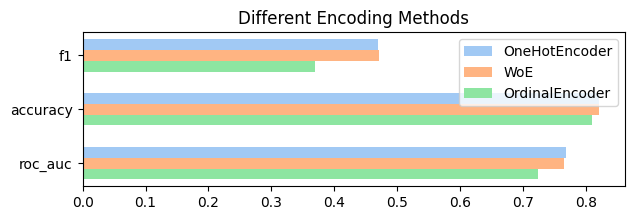

In [98]:
sns.set_palette("pastel")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 2))

encoder_valid = encoder[encoder['dataset']=="validation"].iloc[:, :4].sort_values(by=["roc_auc"], ascending=False)

y = np.arange(encoder_valid.shape[1]-1)
ax.barh(y=y+0.2, width=encoder_valid.iloc[0, 1:], height=0.2, align="center", label=encoder_valid.iloc[0, 0])
ax.barh(y=encoder_valid.columns[1:], width=encoder_valid.iloc[1, 1:], height=0.2, alpha=1, align="center", label=encoder_valid.iloc[1, 0])
ax.barh(y=y-0.2, width=encoder_valid.iloc[2, 1:], height=0.2, alpha=1, align="center", label=encoder_valid.iloc[2, 0])
ax.set_title("Different Encoding Methods")
ax.legend(loc=0)

In [96]:
encoder_valid

,encoder,roc_auc,accuracy,f1
4,WoE,0.765082,0.820083,0.470081
2,OneHotEncoder,0.767605,0.820750,0.469172
0,OrdinalEncoder,0.723004,0.809875,0.368513


# Phase 2

In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=WoEEncoder(fill_value=0.00001),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                          specific_encoders={"gender": LabelEncoder()})
model = RandomForestClassifier(n_estimators=1000)
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
# processor.fit_transform(x_train.iloc[:, 1:], y_train)
cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)

{'roc_auc': 0.7548077105115973,
 'accuracy': 0.7975833333333334,
 'f1': 0.5081281662640469,
 'precision': 0.5510604197165632,
 'recall': 0.47154347135444247}

In [ ]:
output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

models = {"LogisticRegression": LogisticRegression(max_iter=1000),
          "KNN": KNeighborsClassifier(),
          "RandomForest": RandomForestClassifier(),
          "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
          "Catboost": CatBoostClassifier(verbose=False, random_state=42),
          "XGBoost": XGBClassifier(random_state=42),
          "AdaBoost": AdaBoostClassifier(algorithm="SAMME"),
          "ExtraTreesClassifier": ExtraTreesClassifier()}
processor = Preprocessing(scaler=MinMaxScaler(),
                         encoder=WoEEncoder(fill_value=0.00001),
                         numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                         numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
for model_name, model in models.items():
    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
    output["model"].append(model_name)
    for method, score in scores.items():
        output[method].append(score)

In [ ]:
output_df = pd.DataFrame(output)
output_df
# output_df.to_csv("notune_result_validation.csv", index=False)

,model,roc_auc,accuracy,f1,precision,recall
0,LogisticRegression,0.763344,0.781708,0.533403,0.507213,0.562659
1,KNN,0.694528,0.677208,0.455133,0.363885,0.607743
2,RandomForest,0.749753,0.794500,0.499181,0.543481,0.461774
3,LightGBM,0.766674,0.811042,0.506931,0.601878,0.438293
4,Catboost,0.767576,0.812667,0.496004,0.614841,0.415938
5,XGBoost,0.750081,0.799375,0.483663,0.563473,0.424017
6,AdaBoost,0.744629,0.781208,0.517684,0.506522,0.529594
7,ExtraTreesClassifier,0.741595,0.795333,0.491953,0.547410,0.446739


In [ ]:
# output_df.to_csv("../output/csv/phase_2/result_validation.csv", index=False)

In [ ]:
def modelling_evaluation(estimator, x_train, y_train, x_test, y_test, scoring=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    y_pred_proba = estimator.predict_proba(x_test)
    scores = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_proba)
    return scores

In [ ]:
# processor = Preprocessing(scaler=MinMaxScaler(),
#                          encoder=OneHotEncoder(sparse_output=False),
#                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
#                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
#                                                     "30-40", (40, 50): "40-50", (50, 60): "50-60",
#                                                     (60, 100): "over 60"}},
#                          specific_encoders={"gender": LabelEncoder()})

# model = KNeighborsClassifier()
# estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
# # processor.fit_transform(x_train.iloc[:, 1:], y_train)
# # processor.transform(x_test.iloc[:, 1:])
# modelling_evaluation(estimator=estimator, x_train=x_train.iloc[:, 1:], y_train=y_train,
#                      x_test=x_test.iloc[:, 1:], y_test=y_test)

{'roc_auc': 0.6795932617174012,
 'accuracy': 0.6726666666666666,
 'f1': 0.43367935409457903,
 'precision': 0.34895591647331786,
 'recall': 0.5727341964965728}

In [ ]:
output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

models = {"LogisticRegression": LogisticRegression(max_iter=1000),
          "KNN": KNeighborsClassifier(),
          "RandomForest": RandomForestClassifier(),
          "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
          "Catboost": CatBoostClassifier(verbose=False, random_state=42),
          "XGBoost": XGBClassifier(random_state=42),
          "AdaBoost": AdaBoostClassifier(algorithm="SAMME")}
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=WoEEncoder(fill_value=0.00001),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                     (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
for model_name, model in models.items():
    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
    scores = modelling_evaluation(estimator=estimator, x_train=x_train.iloc[:, 1:], y_train=y_train,
                                  x_test=x_test.iloc[:, 1:], y_test=y_test)
    output["model"].append(model_name)
    for method, score in scores.items():
        output[method].append(score)

In [ ]:
output_df = pd.DataFrame(output)
output_df.to_csv("../output/csv/phase_2/notune_result_testing.csv", index=False)

In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                         encoder=OneHotEncoder(),
                         numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                         numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
model = RandomForestClassifier()
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)

In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=OneHotEncoder(handle_unknown="ignore"),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
model = RandomForestClassifier()
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)

In [ ]:
scores

{'roc_auc': 0.9997964701194906,
 'accuracy': 0.9977604166666667,
 'f1': 0.9949551770300481,
 'precision': 0.9942335143490922,
 'recall': 0.9956791525166334}

In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=OneHotEncoder(),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})
model = RandomForestClassifier()
model = LogisticRegression(solver="liblinear", penalty=None)
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)

ValueError: penalty=None is not supported for the liblinear solver

In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                            encoder=WoEEncoder(fill_value=0.00001),
                            numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                            numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                            specific_encoders={"gender": LabelEncoder()})

In [ ]:
x_train

,id,limit_bal,gender,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
21753,21754,80000,female,university,single,24,0,0,0,0,0,0,75125,77353,78321,73731,39643,39457,3503,5001,2092,1218,1445,878
251,252,30000,male,university,single,28,0,0,0,0,0,0,29242,29507,29155,25255,22001,0,5006,1244,851,955,0,0
22941,22942,180000,female,others,married,44,0,0,-1,-1,-1,-1,20916,0,850,0,6881,10340,0,850,0,6881,10340,182
618,619,60000,male,graduate school,single,25,0,0,0,0,0,0,58839,53235,38533,39639,39619,39140,2018,1900,2000,1500,1900,2000
17090,17091,130000,female,university,single,25,0,0,0,0,0,0,111587,112348,114734,117823,120854,123904,4100,4200,5000,5000,5000,10700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,29803,50000,male,university,single,32,0,0,0,0,0,0,52475,53600,55739,55957,29238,6119,2000,3000,1591,72,1134,73421
5390,5391,200000,male,graduate school,single,37,2,2,2,2,2,2,157131,166590,168386,164182,169029,172084,13500,6000,0,7500,6000,4000
860,861,50000,male,graduate school,single,26,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
15795,15796,70000,female,university,single,25,0,0,0,0,2,2,73939,70488,51152,35122,28633,28039,3000,2000,4500,1200,0,1200


In [ ]:
import optuna

def objective(trial):
    # Define hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'sag', 'saga'])

    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-1)

    model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000, tol=tol,
                               class_weight=class_weight, random_state=42)
    
    processor = Preprocessing(scaler=MinMaxScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Access the best hyperparameters and corresponding score
best_params = study.best_params
best_score = study.best_value

print("Best parameters:", best_params)
print("Best score:", best_score)


[I 2024-04-16 18:00:36,030] A new study created in memory with name: no-name-d0355334-d709-4d19-b308-e66db9a09196


[I 2024-04-16 18:00:41,089] Trial 0 finished with value: 0.5329741887611407 and parameters: {'penalty': None, 'C': 3.0707446749665555, 'solver': 'newton-cg', 'class_weight': 'balanced', 'tol': 7.920221726489133e-05}. Best is trial 0 with value: 0.5329741887611407.
[I 2024-04-16 18:00:44,220] Trial 1 finished with value: 0.5318804765506251 and parameters: {'penalty': None, 'C': 0.0024130125475755565, 'solver': 'newton-cg', 'class_weight': 'balanced', 'tol': 0.0024743332667728807}. Best is trial 0 with value: 0.5329741887611407.
[I 2024-04-16 18:00:46,934] Trial 2 finished with value: 0.5321443059549825 and parameters: {'penalty': None, 'C': 5422.943528685991, 'solver': 'lbfgs', 'class_weight': 'balanced', 'tol': 0.002559262652654044}. Best is trial 0 with value: 0.5329741887611407.
[I 2024-04-16 18:01:17,414] Trial 3 finished with value: 0.5342335853161393 and parameters: {'penalty': 'l2', 'C': 732.1861653854511, 'solver': 'saga', 'class_weight': 'balanced', 'tol': 0.000837191024552683}

Best parameters: {'penalty': 'l2', 'C': 68.7407599357735, 'solver': 'saga', 'class_weight': None, 'tol': 0.0012361085031882765}
Best score: 0.5361461619971968


In [ ]:
# # Logistic Regression - lbfgs, sag, saga, newton-cg
# LogisticRegression(**best_params, random_state=42)

# import joblib
# lr1_bestmodel = LogisticRegression(**best_params, random_state=42)
# joblib.dump(lr1_bestmodel, '../models/best_logistic_model_1.pkl')

['../models/best_logistic_model_1.pkl']

In [ ]:
import optuna

def objective_lr_2(trial):
    # Define hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    solver = trial.suggest_categorical('solver', ['saga', 'liblinear'])

    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-1)

    model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000, tol=tol,
                               class_weight=class_weight, random_state=42)
    
    processor = Preprocessing(scaler=MinMaxScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

study_lr_2 = optuna.create_study(direction='maximize')
study_lr_2.optimize(objective_lr_2, n_trials=50)

# Access the best hyperparameters and corresponding score
best_params = study_lr_2.best_params
best_score = study_lr_2.best_value

print("Best parameters:", best_params)
print("Best score:", best_score)

[I 2024-04-16 18:52:02,693] A new study created in memory with name: no-name-950ee73e-1134-4865-ab01-330c97e84a86
[I 2024-04-16 18:52:10,996] Trial 0 finished with value: 0.534082117417006 and parameters: {'penalty': 'l2', 'C': 598.5179241818383, 'solver': 'liblinear', 'class_weight': 'balanced', 'tol': 0.00016949371840059436}. Best is trial 0 with value: 0.534082117417006.
[I 2024-04-16 18:52:14,162] Trial 1 finished with value: 0.5338607722260864 and parameters: {'penalty': 'l1', 'C': 0.29715943342998974, 'solver': 'liblinear', 'class_weight': None, 'tol': 0.006874716319585674}. Best is trial 0 with value: 0.534082117417006.
[I 2024-04-16 18:53:46,679] Trial 2 finished with value: 0.5332177509743914 and parameters: {'penalty': 'l2', 'C': 610.9147925260401, 'solver': 'saga', 'class_weight': None, 'tol': 1.7664168316532155e-05}. Best is trial 0 with value: 0.534082117417006.
[I 2024-04-16 18:53:49,450] Trial 3 finished with value: 0.5315853280464715 and parameters: {'penalty': 'l2', 'C

NameError: name 'study' is not defined

In [ ]:
# best_params = study_lr_2.best_params
# best_score = study_lr_2.best_value

# print("Best parameters:", best_params)
# print("Best score:", best_score)

Best parameters: {'penalty': 'l1', 'C': 0.6780447064618037, 'solver': 'liblinear', 'class_weight': 'balanced', 'tol': 0.0003572581112773949}
Best score: 0.5350640712005635


In [ ]:
# Logistic Regression - lbfgs, sag, saga, newton-cg
LogisticRegression(**best_params, random_state=42)

import joblib
lr1_bestmodel = LogisticRegression(**best_params, random_state=42)
joblib.dump(lr1_bestmodel, '../models/best_logistic_model_2.pkl')

['../models/best_logistic_model_2.pkl']

In [ ]:
import optuna

def objective_lgbm(trial):
    # Define hyperparameters to optimize
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
    }

    model = LGBMClassifier(**params, random_state=42, verbose=-1)
    
    processor = Preprocessing(scaler=MinMaxScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100)

# Access the best hyperparameters and corresponding score
best_params = study_lgbm.best_params
best_score = study_lgbm.best_value

print("Best parameters:", best_params)
print("Best score:", best_score)

[I 2024-04-16 19:25:41,269] A new study created in memory with name: no-name-8d67902e-77a4-43e3-85cd-eab521f85984
[I 2024-04-16 19:25:45,987] Trial 0 finished with value: 0.5115288922225181 and parameters: {'num_leaves': 47, 'learning_rate': 0.0007522640407385718, 'feature_fraction': 0.9958830808937985, 'bagging_fraction': 0.5606151595507012, 'bagging_freq': 6, 'max_depth': 2, 'lambda_l1': 0.05459799112914164, 'lambda_l2': 0.000525556375642098, 'min_child_samples': 6}. Best is trial 0 with value: 0.5115288922225181.
[I 2024-04-16 19:25:51,382] Trial 1 finished with value: 0.5387567635040603 and parameters: {'num_leaves': 39, 'learning_rate': 0.00014910334764375502, 'feature_fraction': 0.2546503511387808, 'bagging_fraction': 0.2628062699131357, 'bagging_freq': 6, 'max_depth': 19, 'lambda_l1': 0.00999125360762728, 'lambda_l2': 0.0013189537768939154, 'min_child_samples': 17}. Best is trial 1 with value: 0.5387567635040603.
[I 2024-04-16 19:25:55,504] Trial 2 finished with value: 0.5307494

Best parameters: {'num_leaves': 16, 'learning_rate': 0.013222989637952803, 'feature_fraction': 0.48871009104469015, 'bagging_fraction': 0.1015707054663378, 'bagging_freq': 7, 'max_depth': 6, 'lambda_l1': 8.011516555721586e-05, 'lambda_l2': 5.376140499766145e-07, 'min_child_samples': 8}
Best score: 0.544819953893212


In [ ]:
import joblib
model = LGBMClassifier(**best_params, random_state=42, verbose=-1)
joblib.dump(model, '../models/lgbm_best.pkl')
best_params

{'num_leaves': 16,
 'learning_rate': 0.013222989637952803,
 'feature_fraction': 0.48871009104469015,
 'bagging_fraction': 0.1015707054663378,
 'bagging_freq': 7,
 'max_depth': 6,
 'lambda_l1': 8.011516555721586e-05,
 'lambda_l2': 5.376140499766145e-07,
 'min_child_samples': 8}

In [ ]:
y_train.unique()

array([0, 1], dtype=int64)

In [ ]:
import optuna

def objective_lgbm(trial):
    # Define hyperparameters to optimize
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
    }

    model = LGBMClassifier(**params, random_state=42, verbose=-1)
    
    processor = Preprocessing(scaler=MinMaxScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100)

# Access the best hyperparameters and corresponding score
best_params = study_lgbm.best_params
best_score = study_lgbm.best_value

print("Best parameters:", best_params)
print("Best score:", best_score)

In [ ]:
processor = Preprocessing(scaler=MinMaxScaler(),
                          encoder=WoEEncoder(fill_value=0.00001),
                          numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                          numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                    "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                    (60, 100): "over 60"}},
                         specific_encoders={"gender": LabelEncoder()})

model = LGBMClassifier(**best_params, random_state=42, verbose=-1)
estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())

cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
modelling_evaluation(x_train=x_train.iloc[:,1:], x_test=x_test.iloc[:, 1:], y_train=y_train, y_test=y_test,
                     estimator=estimator)

{'roc_auc': 0.7714520775082218,
 'accuracy': 0.7891666666666667,
 'f1': 0.5364602418468304,
 'precision': 0.5169491525423728,
 'recall': 0.5575019040365575}